# 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.2)
%matplotlib inline
color = sns.color_palette()

RAW_PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/raw/'
PREPARED_PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/prepared/'

In [2]:
prior_df = pd.read_pickle(PREPARED_PATH + 'prior_df.pkl') # order_product__prior.csv + orders.csv + products.csv
prior_order_feats = pd.read_pickle(PREPARED_PATH + 'prior_order_feats.pkl') # orders.csv + @
prod_feats = pd.read_pickle(PREPARED_PATH + 'prod_feats.pkl') # products.csv + @
user_feats = pd.read_pickle(PREPARED_PATH + 'user_feats.pkl')
user_prod_feats = pd.read_pickle(PREPARED_PATH + 'user_prod_feats.pkl')
orders = pd.read_csv(RAW_PATH + 'orders.csv', dtype={'order_id': np.uint32, 'user_id': np.uint32, 'eval_set': 'category', 'order_number': np.uint8,         
                                                     'order_dow': np.uint8, 'order_hour_of_day': np.uint8, 'days_since_prior_order': np.float16})

# 1. 가설 검정 체크표

# 2. 주말&요일이 구매에 미치는 영향

## 2.1. 특정 요일 & 시간대에 팔리는 제품 패턴이 있나?


## 2.2. 특정 요일 & 시간대에만 구매하는 고객 패턴이 있나?

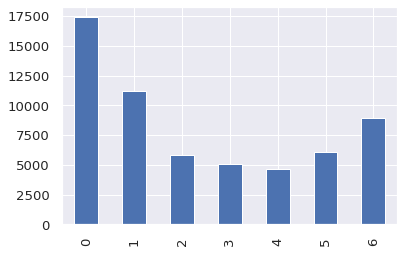

In [46]:
# user_dow = prior_order_feats.groupby(['user_id', 'order_dow']).size().reset_index().rename(columns=({0:'dow_count'}))
# user_dow = user_dow.merge(user_feats[['user_id', 'U_total_orders']], on='user_id', how='left')
# user_dow['percent_of_orders'] = user_dow.dow_count / user_dow.U_total_orders
# user_dow[user_dow.percent_of_orders >=0.5].user_id.nunique() 

# 50% 이상 구매하는 요일이 있는 유저 수 57424

user_dow[user_dow.percent_of_orders >=0.5].order_dow.value_counts().sort_index().plot.bar()

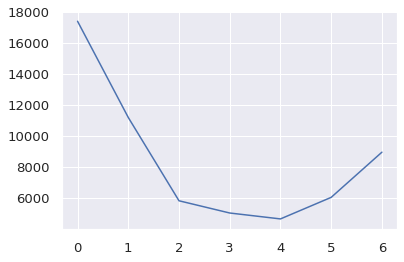

In [47]:
user_dow[user_dow.percent_of_orders >=0.5].order_dow.value_counts().sort_index().plot()

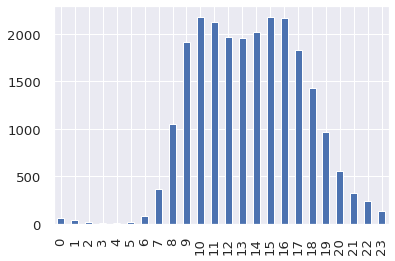

In [51]:
user_hod = prior_order_feats.groupby(['user_id', 'order_hour_of_day']).size().reset_index().rename(columns=({0:'hod_count'}))
user_hod = user_hod.merge(user_feats[['user_id', 'U_total_orders']], on='user_id', how='left')
user_hod['percent_of_orders'] = user_hod.hod_count / user_hod.U_total_orders
user_hod[user_hod.percent_of_orders >=0.5].user_id.nunique() 

# 50% 이상 구매하는 시간이 있는 유저 수 23088

user_hod[user_hod.percent_of_orders >=0.5].order_hour_of_day.value_counts().sort_index().plot.bar()

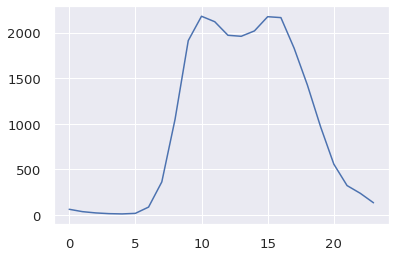

In [52]:
user_hod[user_hod.percent_of_orders >=0.5].order_hour_of_day.value_counts().sort_index().plot()

# 3. Order에서 구매 패턴 확인하기

## 3.1. `order_number(구매횟수)가 높은 주문일수록 재구매율이 높을 것이다`

In [ ]:
order_num_over_40 = prior_df[prior_df.order_number >= 40]
print('평균 재구매 제품 포함 비율 :', prior_order_feats[prior_order_feats.order_number != 1].reorder_in_order.mean())

평균 재구매 제품 포함 비율 : 0.6396946724614132


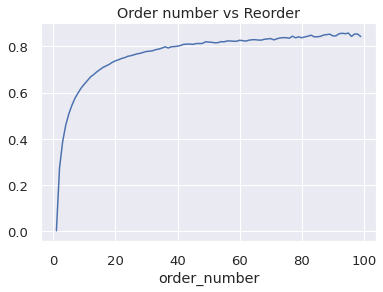

In [ ]:
prior_df.groupby('order_number').reordered.mean().plot()
plt.title('Order number vs Reorder')
plt.show()

In [ ]:
print('전체 데이터 재구매 비율 :', prior_df[prior_df.order_number != 1].reordered.mean())

전체 데이터 재구매 비율 : 0.6300655798652944


In [ ]:
print('40회 이상 주문한 유저 수 :', order_num_over_40.user_id.nunique())

40회 이상 주문한 유저 수 : 17902


In [ ]:
print('전체 주문에서 40회 이상 주문 비율 :', order_num_over_40.order_id.nunique() / prior_order_feats.shape[0])

전체 주문에서 40회 이상 주문 비율 : 0.11253722540914511


In [ ]:
# 40회 이상 주문 제품 정보
order_num_over_40_prods = order_num_over_40.astype({'product_name': np.object0}).groupby('product_name').agg(total_orders=('product_id','count'), 
                                                                              total_reorders=('reordered', 'sum')).sort_values('total_orders')[::-1].reset_index()
order_num_over_40_prods

,product_name,total_orders,total_reorders
0,Bag of Organic Bananas,59102,57546.0
1,Banana,52271,51293.0
2,Organic Strawberries,31428,30444.0
3,Organic Hass Avocado,29910,29011.0
4,Organic Baby Spinach,27652,26687.0
...,...,...,...
38001,Strong & Kind Roasted Jalapeno Almond Protein Bar,1,1.0
38002,Flavor Blasted Xtra Cheddar + Pretzal Baked Sn...,1,0.0
38003,Flavor Blasted Wild White Cheddar Goldfish Cra...,1,0.0
38004,Flat to Volume Pantene Pro-V Sheer Volume Sham...,1,0.0


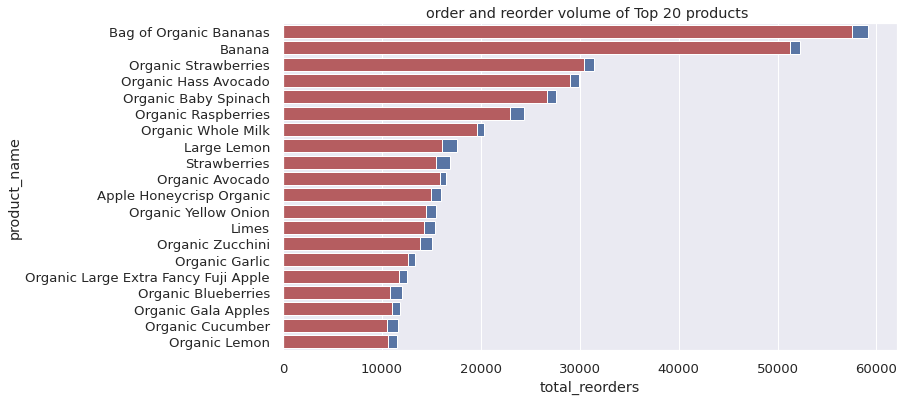

In [ ]:
plt.figure(figsize=(11, 6))
plt.title('order and reorder volume of Top 20 products')
sns.barplot(x='total_orders', y='product_name', data=order_num_over_40_prods.head(20), color=color[0])
sns.barplot(x='total_reorders', y='product_name', data=order_num_over_40_prods.head(20), color=color[3])
plt.show()

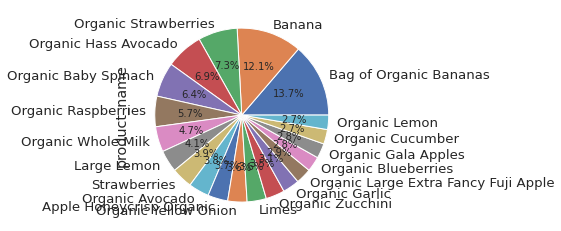

In [ ]:
order_num_over_40.product_name.value_counts().head(20).plot.pie(autopct='%1.1f%%')
plt.show()

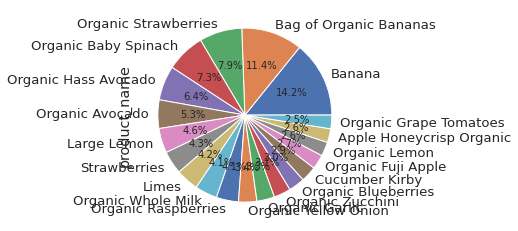

In [ ]:
prior_df.product_name.value_counts().head(20).plot.pie(autopct='%1.1f%%')
plt.show()

In [ ]:
# 40회 이상 주문과 전체 주문 제품 판매량 비교
# order_num_over_40_prods.head(20).join(prod_feats[['product_name', 'P_total_orders', 'P_total_reorders']].head(20), )
pd.concat([order_num_over_40_prods.head(20).reset_index(drop=True), prod_feats[['product_name', 'P_total_orders', 'P_total_reorders']].head(20)],axis=1)

,product_name,total_orders,total_reorders,product_name,P_total_orders,P_total_reorders
0,Bag of Organic Bananas,59102,57546.0,Banana,472565,398609.0
1,Banana,52271,51293.0,Bag of Organic Bananas,379450,315913.0
2,Organic Strawberries,31428,30444.0,Organic Strawberries,264683,205845.0
3,Organic Hass Avocado,29910,29011.0,Organic Baby Spinach,241921,186884.0
4,Organic Baby Spinach,27652,26687.0,Organic Hass Avocado,213584,170131.0
5,Organic Raspberries,24388,22959.0,Organic Avocado,176815,134044.0
6,Organic Whole Milk,20307,19625.0,Large Lemon,152657,106255.0
7,Large Lemon,17632,16112.0,Strawberries,142951,99802.0
8,Strawberries,16843,15430.0,Limes,140627,95768.0
9,Organic Avocado,16478,15889.0,Organic Whole Milk,137905,114510.0


In [ ]:
# 마지막 주문에서 order_nuber 40이상의 비율
orders[(orders.eval_set != 'prior') & (orders.order_number >= 40)].shape[0] / orders[(orders.eval_set != 'prior')].shape[0]

0.09107264959337372

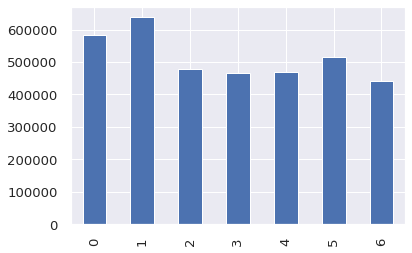

In [ ]:
# 40회 이상 유저들이 주로 구매하는 요일
order_num_over_40.order_dow.value_counts().sort_index().plot.bar()
plt.show()

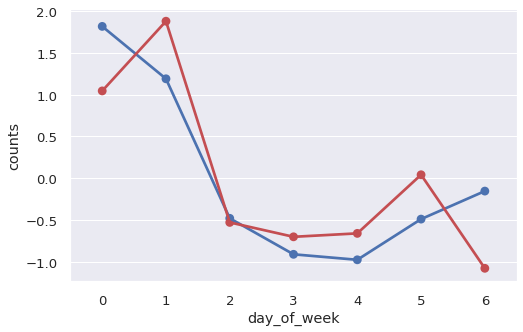

In [ ]:
from sklearn.preprocessing import StandardScaler

total_orders = prior_df.order_dow.value_counts().reset_index().rename(columns=({'index': 'day_of_week', 
                                                                                'order_dow': 'counts'})).set_index('day_of_week')
over_40 = order_num_over_40.order_dow.value_counts().reset_index().rename(columns=({'index': 'day_of_week', 
                                                                                    'order_dow': 'counts'})).set_index('day_of_week')

ss = StandardScaler()
total_orders['counts'] = ss.fit_transform(total_orders)
over_40['counts'] = ss.fit_transform(over_40)

plt.figure(figsize=(8, 5))
sns.pointplot(x=total_orders.index, y='counts', data=total_orders, color=color[0], label='total')
sns.pointplot(x=over_40.index, y='counts', data=over_40, color=color[3], label='over40')
plt.show()

In [ ]:
total_orders = prior_df.order_hour_of_day.value_counts().reset_index().rename(columns=({'index': 'day_of_week', 
                                                                                'order_hour_of_day': 'counts'})).set_index('day_of_week')
over_40 = order_num_over_40.order_hour_of_day.value_counts().reset_index().rename(columns=({'index': 'day_of_week', 
                                                                                    'order_hour_of_day': 'counts'})).set_index('day_of_week')

ss = StandardScaler()
total_orders['counts'] = ss.fit_transform(total_orders)
over_40['counts'] = ss.fit_transform(over_40)

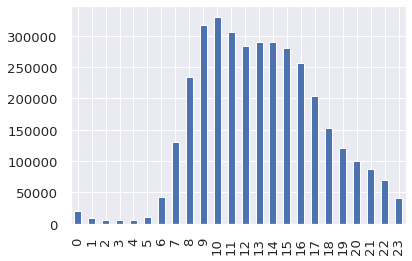

In [ ]:
# 40회 이상 유저들이 주로 구매하는 시간
order_num_over_40.order_hour_of_day.value_counts().sort_index().plot.bar()
plt.show()

## 3.2. `days_since_prior_order가 짧은 주문일수록 재구매율이 높을 것이다`


In [ ]:
prior_order_feats.head()

,user_id,order_number,basket_size,reorder_in_order,order_dow,order_hour_of_day,days_since_prior_order,order_id
0,1,1,5,0.000,2,8,NaN,2539329
1,1,2,6,0.500,3,7,15.0,2398795
2,1,3,5,0.600,3,12,21.0,473747
3,1,4,5,1.000,4,7,29.0,2254736
4,1,5,8,0.625,4,15,28.0,431534


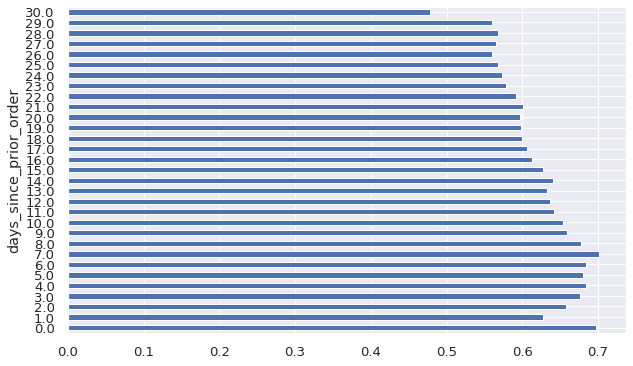

In [ ]:
plt.figure(figsize=(10, 6))
prior_order_feats.groupby('days_since_prior_order').reorder_in_order.mean().plot.barh()

In [ ]:
# 재주문 기간 별 평균 재주문 제품 포함 비율
prior_order_feats.groupby('days_since_prior_order').reorder_in_order.mean()

days_since_prior_order
0.0     0.697275
1.0     0.626863
2.0     0.658052
3.0     0.676392
4.0     0.683834
5.0     0.680283
6.0     0.684224
7.0     0.701646
8.0     0.676970
9.0     0.658714
10.0    0.654191
11.0    0.642443
12.0    0.636483
13.0    0.633204
14.0    0.640056
15.0    0.627351
16.0    0.613181
17.0    0.606415
18.0    0.599964
19.0    0.598253
20.0    0.597318
21.0    0.600399
22.0    0.591121
23.0    0.578212
24.0    0.572575
25.0    0.568141
26.0    0.560020
27.0    0.565067
28.0    0.567501
29.0    0.559942
30.0    0.477778
Name: reorder_in_order, dtype: float64

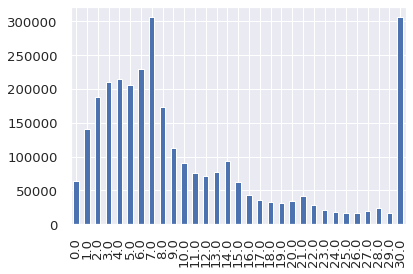

In [ ]:
prior_order_feats.days_since_prior_order.value_counts().sort_index().plot.bar()

In [ ]:
# 재주문 기간 별 주문 수
prior_order_feats.days_since_prior_order.value_counts().sort_index()

0.0      64436
1.0     141011
2.0     187723
3.0     210665
4.0     214488
5.0     206691
6.0     230245
7.0     306181
8.0     173259
9.0     112184
10.0     90198
11.0     76394
12.0     71356
13.0     77765
14.0     93064
15.0     61883
16.0     43423
17.0     36281
18.0     33050
19.0     31408
20.0     35173
21.0     41262
22.0     29125
23.0     21629
24.0     18704
25.0     17324
26.0     17120
27.0     19677
28.0     23833
29.0     16976
30.0    306137
Name: days_since_prior_order, dtype: int64

## 3.3. 한번의 주문에 구매하는 제품 수량에 따라 구매패턴이 다를 것이다

# 4. 고객별 구매 패턴

## 4.1. 유저 개개인은 선호하는 제품 or 구매 패턴이 존재할 것 이다.



In [ ]:
# 유저마다 주문율 80%이상인 제품이 있는지 확인. 이 유저는 이건 매번 사더라
print('유저별 전체 주문에서 80%이상 구매한 제품이 있는 유저 수 :', user_prod_feats[user_prod_feats.UP_order_percentage >= 0.8].user_id.nunique())

유저별 전체 주문에서 80%이상 구매한 제품이 있는 유저 수 : 72113


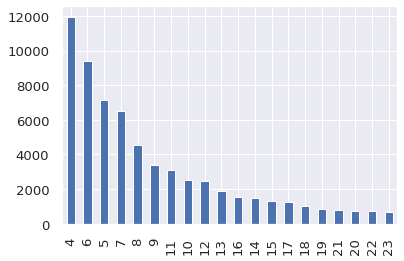

In [ ]:
# 위의 유저들의 order_number 확인
orders[orders.user_id.isin(user_prod_feats[user_prod_feats.UP_order_percentage >= 0.8].user_id.unique())].groupby('user_id').order_number.max().value_counts().head(20).plot.bar()
plt.show()

In [8]:
user_prod_feats[user_prod_feats.UP_order_percentage >= 0.8].groupby('product_name').product_id.count().sort_values()[::-1].reset_index().rename(columns={'product_id': 'count'}).head(20)

,product_name,count
0,Banana,8258
1,Bag of Organic Bananas,4639
2,Organic Avocado,1904
3,Organic Baby Spinach,1724
4,Organic Whole Milk,1700
5,Organic Hass Avocado,1402
6,Organic Strawberries,1154
7,Spring Water,1066
8,Sparkling Water Grapefruit,864
9,Strawberries,830


## 4.2. 같은 제품을 우선순위로 두는 유저들의 구매 패턴은 비슷할 것 이다.

In [ ]:
def make_band(x):
    if x < 2:
        return 1
    if x < 3:
        return 2
    if x < 4:
        return 3
    if x < 5:
        return 4
    if x < 6:
        return 5
    if x < 7:
        return 6
    if x < 8:
        return 7
    if x < 9:
        return 8
    if x < 10:
        return 9
    if x < 11:
        return 10
    if x < 12:
        return 11
    if x < 13:
        return 12
    if x < 14:
        return 13

user_prod_feats['UP_mean_cart_order_band'] = user_prod_feats[user_prod_feats.UP_mean_cart_order <= 14].UP_mean_cart_order.apply(make_band)
user_prod_feats.head()

,user_id,product_id,UP_total_orders,UP_total_reorders,UP_first_order_num,UP_mean_cart_order,UP_reorder_ratio,UP_order_percentage,UP_order_3,UP_order_2,UP_order_1,UP_mean_cart_order_band
0,1,196,10,9,1,1.400000,1.00,1.0,1,1,1,1.0
1,1,12427,10,9,1,3.300000,1.00,1.0,1,1,1,3.0
2,1,10258,9,8,2,3.333333,1.00,0.9,1,1,1,3.0
3,1,25133,8,7,3,4.000000,1.00,0.8,1,1,1,4.0
4,1,13032,3,2,2,6.333333,0.25,0.3,1,-1,-1,6.0


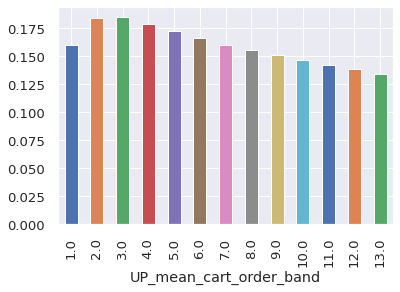

In [ ]:
# 평균 장바구니 순위 14이하 별 주문율
user_prod_feats.groupby('UP_mean_cart_order_band').UP_order_percentage.mean().plot.bar(color=color)
plt.show()

In [ ]:
# volume_over_30 = prod_feats.head(int(prod_feats.shape[0] * 0.30))
volume_over_30.head()

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department,dspo_band
0,24852,472565,73956,398609.0,0.843501,4.894129,4174732.0,56.448861,9.997801,Banana,...,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,10
1,13176,379450,63537,315913.0,0.832555,5.095947,2985543.0,46.989046,8.648257,Bag of Organic Bananas,...,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,9
2,21137,264683,58838,205845.0,0.777704,7.248902,1902667.0,32.337384,7.392364,Organic Strawberries,...,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,8
3,21903,241921,55037,186884.0,0.772500,7.429640,1973413.0,35.856115,8.417183,Organic Baby Spinach,...,8.399527,5.108206,packaged vegetables fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,9
4,47209,213584,43453,170131.0,0.796553,6.775011,1615360.0,37.174879,7.814569,Organic Hass Avocado,...,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,8


In [ ]:
volume_over_30.sort_values(['P_mean_cart_order', 'P_reorder_rate'], ascending=([True, False]))

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department,dspo_band
11968,31380,277,137,140.0,0.505415,2.628159,2691.0,19.642336,7.866771,Omeprazole Acid Reducer Tablets,...,7.829159,2.360676,digestion,447123,143584.0,0.321129,8.752753,1.727874,personal care,8
2528,35470,2244,389,1855.0,0.826649,2.688948,20892.0,53.706941,9.938788,Water Mineral,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,10
7345,42791,600,220,380.0,0.633333,2.746667,6436.0,29.254545,8.060704,Minis to Go Natural Spring Water,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,9
9656,49463,394,131,263.0,0.667513,2.875635,4428.0,33.801527,10.141673,Organic Whole Bean Coffee,...,7.208847,4.294433,coffee,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,11
12899,1071,243,95,148.0,0.609053,2.880658,1665.0,17.526316,6.067930,Pils,...,5.342315,3.703812,beers coolers,153696,87595.0,0.569924,5.428346,3.471192,alcohol,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11278,7347,306,148,158.0,0.516340,14.245098,1306.0,8.824324,2.252465,Kiwi Beet & Pear Strawberry Pouch,...,10.762161,3.744503,baby food formula,423802,245369.0,0.578971,10.575925,3.611420,babies,3
14237,40863,202,145,57.0,0.282178,14.801980,370.0,2.551724,1.316437,Summer Vegetable Dinner Stage 2,...,10.762161,3.744503,baby food formula,423802,245369.0,0.578971,10.575925,3.611420,babies,2
11715,12822,288,210,78.0,0.270833,14.809028,384.0,1.828571,0.656389,Pureed Baby Food Strawberries Carrots,...,10.762161,3.744503,baby food formula,423802,245369.0,0.578971,10.575925,3.611420,babies,1
11642,3888,291,85,206.0,0.707904,15.000000,1865.0,21.941176,4.347333,Organic Chile Lemon Pistachio,...,9.319779,3.124956,nuts seeds dried fruit,2887550,1657973.0,0.574180,9.187743,3.943013,snacks,5


In [ ]:
user_prod_feats.columns

Index(['user_id', 'product_id', 'UP_total_orders', 'UP_total_reorders',
       'UP_mean_cart_order', 'U_total_orders', 'UP_reorder_ratio',
       'UP_order_percentage', 'UP_order_days',
       'UP_mean_days_since_prior_order', 'UP_order_3', 'UP_order_2',
       'UP_order_1', 'product_name', 'aisle_id', 'department_id'],
      dtype='object')

In [ ]:
user_prod_feats.sort_values(['UP_mean_cart_order', 'UP_total_orders'], ascending=[True, False]).head(10)

,user_id,product_id,UP_total_orders,UP_total_reorders,UP_mean_cart_order,U_total_orders,UP_reorder_ratio,UP_order_percentage,UP_order_days,UP_mean_days_since_prior_order,UP_order_3,UP_order_2,UP_order_1,product_name,aisle_id,department_id
11155119,172689,1463,52,51,1.0,60,0.864407,0.866667,208,4.078432,1,1,1,Organic Milk,84,16
13112040,203143,48239,50,49,1.0,53,0.942308,0.943396,269,5.489796,1,1,1,Cocoa Spread with Hazelnuts,88,13
5558214,85854,34050,49,48,1.0,51,0.960000,0.960784,348,7.250000,-1,1,1,Orange Juice,31,7
6866806,105998,10602,49,48,1.0,49,1.000000,1.000000,262,5.458333,1,1,1,Brioche Hamburger Buns,43,3
10991151,170174,32478,47,46,1.0,47,1.000000,1.000000,280,6.086957,1,1,1,Reduced Fat 2% Milk,84,16
763118,12025,34050,45,44,1.0,45,1.000000,1.000000,316,7.181818,1,1,1,Orange Juice,31,7
10688249,165398,19660,44,43,1.0,61,0.767857,0.721311,282,6.558139,1,1,1,Spring Water,115,7
4603475,71217,22046,39,38,1.0,44,0.883721,0.886364,319,8.394737,1,-1,1,Frozen Whole Strawberries,116,1
12110815,187579,19660,39,38,1.0,39,1.000000,1.000000,204,5.368421,1,1,1,Spring Water,115,7
11170984,172935,6137,38,37,1.0,38,1.000000,1.000000,225,6.081081,1,1,1,Merlot,28,5


In [ ]:
prior_df[prior_df.add_to_cart_order == 1].product_id.nunique()

41826

In [ ]:
# 제품별로 카트에 담긴 평균을 낸 후, p_mean_cart_order가 낮은 제품 중 판매량이 높은 제품리스트을를 확인하려 했으나
# 평균 카트 순위와 제품의 판매량은 상관관계가 보이지 않아 멈춤
volume_over_30.sort_values('P_mean_cart_order').head(10)

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department,dspo_band
11968,31380,277,137,140.0,0.505415,2.628159,2691.0,19.642336,7.866771,Omeprazole Acid Reducer Tablets,...,7.829159,2.360676,digestion,447123,143584.0,0.321129,8.752753,1.727874,personal care,8
2528,35470,2244,389,1855.0,0.826649,2.688948,20892.0,53.706941,9.938788,Water Mineral,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,10
7345,42791,600,220,380.0,0.633333,2.746667,6436.0,29.254545,8.060704,Minis to Go Natural Spring Water,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,9
9656,49463,394,131,263.0,0.667513,2.875635,4428.0,33.801527,10.141673,Organic Whole Bean Coffee,...,7.208847,4.294433,coffee,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,11
12899,1071,243,95,148.0,0.609053,2.880658,1665.0,17.526316,6.067930,Pils,...,5.342315,3.703812,beers coolers,153696,87595.0,0.569924,5.428346,3.471192,alcohol,7
588,20940,8438,1398,7040.0,0.834321,2.881251,93742.0,67.054363,12.102471,Organic Low Fat Milk,...,5.570370,6.848756,milk,5414016,3627221.0,0.669969,7.495423,5.249701,dairy eggs,13
3475,11885,1556,394,1162.0,0.746787,2.902956,15224.0,38.639594,7.969280,"Sparkling Water, Bottles",...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,8
8412,12640,490,127,363.0,0.740816,2.983673,5533.0,43.566929,9.244006,Sport Bottle with Flip Cap Natural Spring Water,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,10
2542,26900,2231,782,1449.0,0.649485,3.012999,20644.0,26.398977,8.955139,USDA AA Extra Large Eggs,...,6.430567,6.685965,eggs,5414016,3627221.0,0.669969,7.495423,5.249701,dairy eggs,9
9292,4100,419,93,326.0,0.778043,3.047733,3766.0,40.494624,8.795648,Organic Dark Roast,...,7.208847,4.294433,coffee,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,9


# 5. 제품별 판매 패턴

## 5.1. 고객들이 선호하는 제품 키워드가 존재하고 재주문율이 높을 것이다. 

### 5.1.1. word cloud로 제품 키워드 파악 후 키워드 별 재주문율 확인

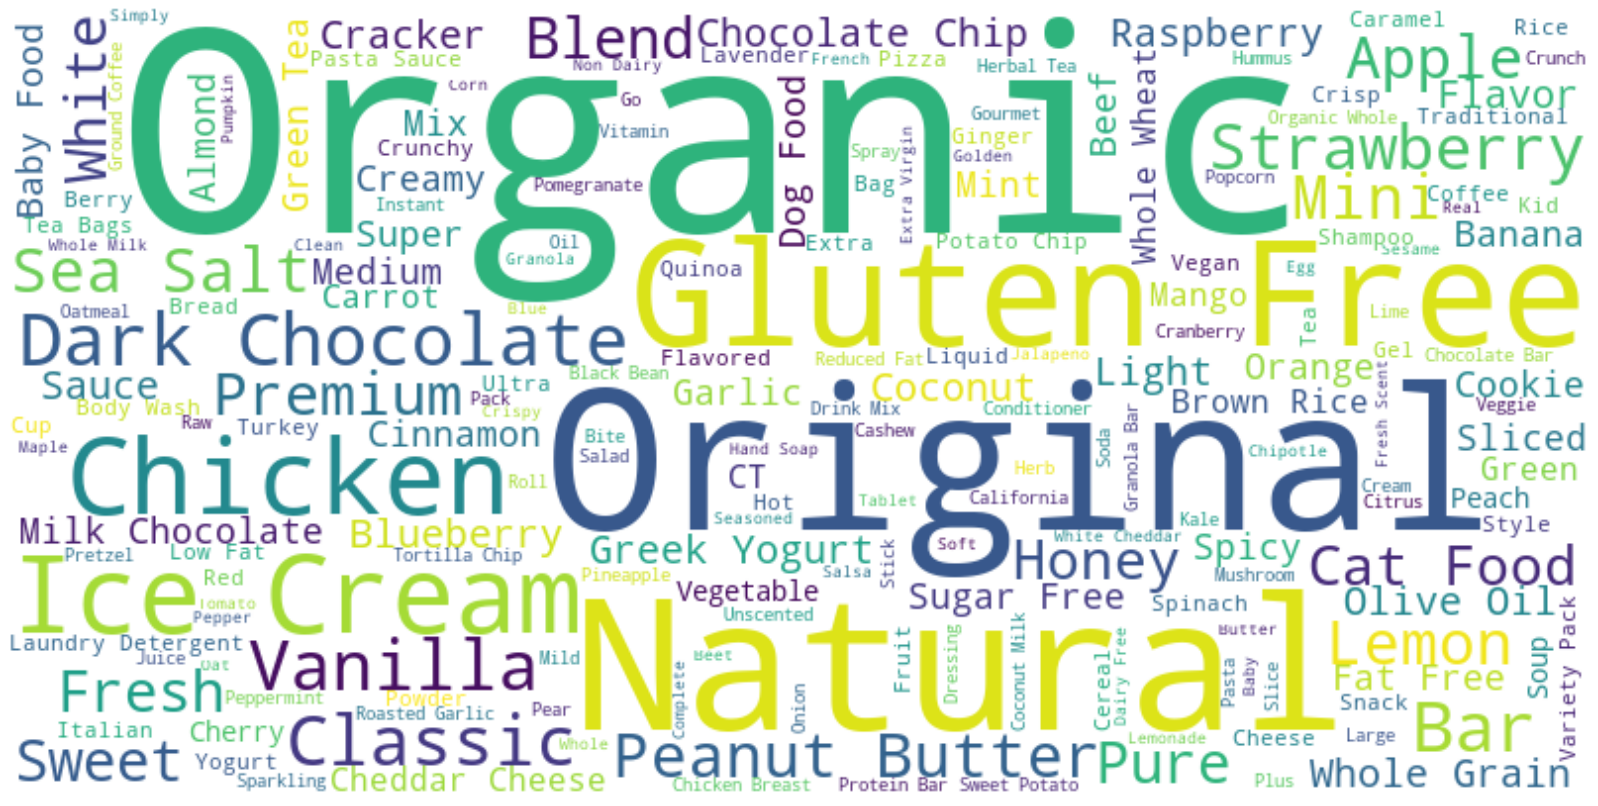

In [ ]:
# 제품 종류내
from wordcloud import WordCloud,ImageColorGenerator

#making of word cloud from Product name column
text = " ".join(topic for topic in prod_feats.product_name.astype(str))
print ("There are {} words in the combination of all Product Name.".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

plt.axis("off")
plt.rcParams["figure.figsize"] = (23,11)
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
# 단어 리스트 생성
word_list_lower =  ["organic", 'fat', "whole", "reduced", 'baby', "water", "banana", "greek", "hass", "strawberry", "honey", 'half']
word_list_upper = ["Organic", 'Fat', "Whole", "Reduced", "Baby", "Water", "Banana", "Greek", "Hass", "Strawberry", "Honey", 'Half']

In [ ]:
# 단어가 포함된 제품과 그렇지 않은 제품의 재주문율 비교
def is_name(word_low, word_up, df):  
    df[word_low] = df.product_name.apply(lambda x: 1 if word_low in x or word_up in x else 0)
    print(word_up, df.groupby(word_low)['reordered'].mean())

In [ ]:
# 1차
df = prior_df.copy()
for word_low, word_up in zip(word_list_lower, word_list_upper):
    is_name(word_low, word_up, df)

Organic organic
0    0.568799
1    0.634926
Name: reordered, dtype: float64
Fat fat
0    0.584969
1    0.700573
Name: reordered, dtype: float64
Natural natural
0    0.590096
1    0.571313
Name: reordered, dtype: float64
Chicken chicken
0    0.590719
1    0.548342
Name: reordered, dtype: float64
Baby baby
0    0.587684
1    0.651103
Name: reordered, dtype: float64
Ice Cream ice cream
0    0.590522
1    0.489287
Name: reordered, dtype: float64
Sweet sweet
0    0.589612
1    0.592591
Name: reordered, dtype: float64
Greek greek
0    0.587902
1    0.682447
Name: reordered, dtype: float64
Free free
0    0.589336
1    0.598605
Name: reordered, dtype: float64
Fresh fresh
0    0.590715
1    0.513731
Name: reordered, dtype: float64
Classic classic
0    0.590198
1    0.527083
Name: reordered, dtype: float64
Premium premium
0    0.590095
1    0.504240
Name: reordered, dtype: float64
Chocolate chocolate
0    0.590275
1    0.569555
Name: reordered, dtype: float64
Strawberry strawberry
0    0.589172


In [ ]:
# 2차
for word_low, word_up in zip(word_list_lower, word_list_upper):
    is_name(word_low, word_up, df)

Organic organic
0    0.568799
1    0.634926
Name: reordered, dtype: float64
Fat fat
0    0.584969
1    0.700573
Name: reordered, dtype: float64
Whole whole
0    0.587086
1    0.655623
Name: reordered, dtype: float64
Reduced reduced
0    0.588148
1    0.735362
Name: reordered, dtype: float64
Baby baby
0    0.587684
1    0.651103
Name: reordered, dtype: float64
Water water
0    0.585755
1    0.702736
Name: reordered, dtype: float64
Banana banana
0    0.582836
1    0.799929
Name: reordered, dtype: float64
Greek greek
0    0.587902
1    0.682447
Name: reordered, dtype: float64
Hass hass
0    0.587923
1    0.755085
Name: reordered, dtype: float64
Gluten gluten
0    0.590085
1    0.563921
Name: reordered, dtype: float64
Strawberry strawberry
0    0.589172
1    0.625552
Name: reordered, dtype: float64
Honey honey
0    0.589160
1    0.621237
Name: reordered, dtype: float64
Cream cream
0    0.591216
1    0.542048
Name: reordered, dtype: float64


In [ ]:
is_name('half', 'Half', df)

Half half
0    0.588802
1    0.737455
Name: reordered, dtype: float64


In [ ]:
is_name('sugar', 'Sugar', df)

Sugar sugar
0    0.590602
1    0.462926
Name: reordered, dtype: float64


In [ ]:
is_name('sodium', 'Sodium', df)

Sodium sodium
0    0.590269
1    0.432693
Name: reordered, dtype: float64


In [ ]:
df.groupby('water').reordered.mean()

water
0    0.585755
1    0.702736
Name: reordered, dtype: float64

# 기본 정보

- 총 유저 수 : 206,209
- 총 주문 수 : 3,421,083
- 마지막 주문 중 64%는 훈련데이터, 36%는 테스트 데이터다. (131,209),(75,000)
- 유저별 최소 주문 수 4 / 최대 주문 수 100 / 평균 16.6
- 전체 판매 제품 수 : 32,434,489
- 주문당 평균 구매 제품 수 : 10
- 총 제품 수 : 49,688

In [ ]:
prod_feats

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_reorder_rate,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department
0,24852,472565,73956,398609.0,0.843501,4.894129,4174732.0,56.448861,9.997801,Banana,...,0.718104,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce
1,13176,379450,63537,315913.0,0.832555,5.095947,2985543.0,46.989046,8.648257,Bag of Organic Bananas,...,0.718104,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce
2,21137,264683,58838,205845.0,0.777704,7.248902,1902667.0,32.337384,7.392364,Organic Strawberries,...,0.718104,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce
3,21903,241921,55037,186884.0,0.772500,7.429640,1973413.0,35.856115,8.417183,Organic Baby Spinach,...,0.638514,8.399527,5.108206,packaged vegetables fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce
4,47209,213584,43453,170131.0,0.796553,6.775011,1615360.0,37.174879,7.814569,Organic Hass Avocado,...,0.718104,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49672,45893,1,1,0.0,0.000000,8.000000,-1.0,-1.000000,-1.000000,Florentine Spinach & Cheese Pasta Sauce,...,0.478953,10.167162,3.576087,pasta sauce,866627,399581.0,0.461076,10.212863,3.272751,dry goods pasta
49673,13397,1,1,0.0,0.000000,34.000000,-1.0,-1.000000,-1.000000,"Molasses, Bead",...,0.351132,9.751061,1.656321,asian foods,269253,99416.0,0.369229,9.947061,1.965495,international
49674,30451,1,1,0.0,0.000000,21.000000,-1.0,-1.000000,-1.000000,"Pasta & Enchilada Sauce, Organic, 7 Veggie",...,0.478953,10.167162,3.576087,pasta sauce,866627,399581.0,0.461076,10.212863,3.272751,dry goods pasta
49675,42464,1,1,0.0,0.000000,16.000000,-1.0,-1.000000,-1.000000,Organic Aleppo Pepper,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry


In [ ]:
prod_feats[prod_feats.P_total_reorders != 0].head(int(prod_feats.shape[0] * 0.30)).P_total_orders.min()

185

In [ ]:
prod_feats[prod_feats.P_total_reorders != 0].head(int(prod_feats.shape[0] * 0.30)).sort_values('P_days_since_prior_order').head(20)

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_reorder_rate,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department
14222,11672,203,202,1.0,0.004926,10.714286,-194.0,-0.960396,-0.960396,Ground Sage,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
12850,2053,244,238,6.0,0.024590,10.463115,-220.0,-0.924370,-0.924370,Organic Ground Coriander,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
13475,46777,224,217,7.0,0.031250,9.468750,-192.0,-0.884793,-0.903226,Organic Poppy Seed,...,0.519170,9.319779,3.124956,nuts seeds dried fruit,2887550,1657973.0,0.574180,9.187743,3.943013,snacks
7303,44626,605,589,16.0,0.026446,10.039669,-527.0,-0.894737,-0.899264,Ground Allspice,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
13211,22087,233,226,7.0,0.030043,10.643777,-176.0,-0.778761,-0.834071,Whole Celery Seed,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
11099,47385,313,306,7.0,0.022364,10.335463,-255.0,-0.833333,-0.833333,Ground Mustard,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
6951,6288,647,631,16.0,0.024730,9.775889,-514.0,-0.814580,-0.832541,Ground Cloves,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
10543,1719,340,328,12.0,0.035294,10.279412,-272.0,-0.829268,-0.830793,Organic Ground Mustard Seed,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
8848,28741,454,443,11.0,0.024229,10.348018,-341.0,-0.769752,-0.821294,Organic Ground Cloves,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
4838,42421,1055,1018,37.0,0.035071,10.445498,-792.0,-0.777996,-0.816306,Organic Ground Nutmeg,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry


In [ ]:
a = prod_feats[prod_feats.P_total_reorders != 0].head(int(prod_feats.shape[0] * 0.30)).sort_values('P_days_since_prior_order')
a

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_reorder_rate,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department
14222,11672,203,202,1.0,0.004926,10.714286,-194.0,-0.960396,-0.960396,Ground Sage,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
12850,2053,244,238,6.0,0.024590,10.463115,-220.0,-0.924370,-0.924370,Organic Ground Coriander,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
13475,46777,224,217,7.0,0.031250,9.468750,-192.0,-0.884793,-0.903226,Organic Poppy Seed,...,0.519170,9.319779,3.124956,nuts seeds dried fruit,2887550,1657973.0,0.574180,9.187743,3.943013,snacks
7303,44626,605,589,16.0,0.026446,10.039669,-527.0,-0.894737,-0.899264,Ground Allspice,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
13211,22087,233,226,7.0,0.030043,10.643777,-176.0,-0.778761,-0.834071,Whole Celery Seed,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13484,43826,224,61,163.0,0.727679,7.437500,2351.0,38.540984,10.118805,Original Flavor Freshly Popped Rice Cakes,...,0.569144,9.441517,4.227208,crackers,2887550,1657973.0,0.574180,9.187743,3.943013,snacks
9656,49463,394,131,263.0,0.667513,2.875635,4428.0,33.801527,10.141673,Organic Whole Bean Coffee,...,0.619727,7.208847,4.294433,coffee,2690129,1757892.0,0.653460,6.976699,4.778593,beverages
8701,17469,467,67,400.0,0.856531,3.152034,4652.0,69.432836,10.921287,Lo-Carb Energy Drink,...,0.649607,6.777233,4.725098,energy sports drinks,2690129,1757892.0,0.653460,6.976699,4.778593,beverages
2946,17924,1889,431,1458.0,0.771837,3.118581,23033.0,53.440835,11.445799,Seltzer Water,...,0.729593,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages


In [ ]:
prod_feats[prod_feats.P_total_reorders != 0].head(int(prod_feats.shape[0] * 0.30)).sort_values('P_total_reorders').head(20)

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_reorder_rate,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department
14222,11672,203,202,1.0,0.004926,10.714286,-194.0,-0.960396,-0.960396,Ground Sage,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
12850,2053,244,238,6.0,0.024590,10.463115,-220.0,-0.924370,-0.924370,Organic Ground Coriander,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
13475,46777,224,217,7.0,0.031250,9.468750,-192.0,-0.884793,-0.903226,Organic Poppy Seed,...,0.519170,9.319779,3.124956,nuts seeds dried fruit,2887550,1657973.0,0.574180,9.187743,3.943013,snacks
11099,47385,313,306,7.0,0.022364,10.335463,-255.0,-0.833333,-0.833333,Ground Mustard,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
13211,22087,233,226,7.0,0.030043,10.643777,-176.0,-0.778761,-0.834071,Whole Celery Seed,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
13047,22432,238,229,9.0,0.037815,10.668067,-177.0,-0.772926,-0.812227,Coriander,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
10735,14688,329,320,9.0,0.027356,9.389058,-257.0,-0.803125,-0.812500,Bamboo Skewers,...,0.195377,8.890100,0.366596,kitchen supplies,738666,297075.0,0.402178,8.492163,2.650132,household
12288,12589,265,256,9.0,0.033962,8.366038,-183.0,-0.714844,-0.714844,Birthday Candles,...,0.167229,9.212266,0.285277,baking supplies decor,1875577,650301.0,0.346721,9.593425,1.761969,pantry
11618,40559,292,282,10.0,0.034247,9.910959,-199.0,-0.705674,-0.709220,Celery Salt,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry
14740,26976,189,179,10.0,0.052910,9.502646,-41.0,-0.229050,-0.229050,Perfect Pinch Cajun Seasoning,...,0.152391,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry


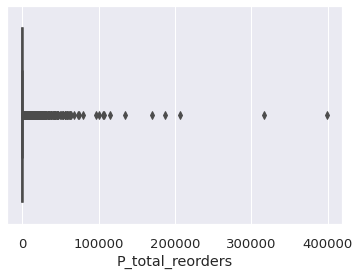

In [ ]:
a

전체 판매량 : 32434489 건


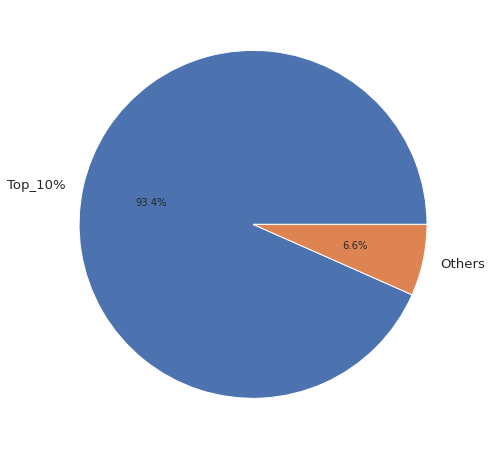

In [ ]:
top_ten = int(prod_feats.shape[0] * 0.25) # 4967
print('전체 판매량 :', prior_df.shape[0], '건')
plt.figure(figsize=(10, 8))
pd.Series({'Top_10%':prod_feats.head(top_ten)['P_total_orders'].sum(), 'Others': prior_df.shape[0] - prod_feats.head(top_ten)['P_total_orders'].sum()}).plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

In [ ]:
prod_feats

count     49677.000000
mean        385.017936
std        3601.713646
min           0.000000
25%           4.000000
50%          22.000000
75%         115.000000
max      398609.000000
Name: P_total_reorders, dtype: float64

In [ ]:
def make_band(x):
    if -1 <= x < 0:
        return 0
    if 0 <= x < 1:
        return 1
    if 1 <= x < 2:
        return 2
    if 2 <= x < 3:
        return 3
    if 3 <= x < 4:
        return 4
    if 4 <= x < 5:
        return 5
    if 5 <= x < 6:
        return 6
    if 6 <= x < 7:
        return 7
    if 7 <= x < 8:
        return 8
    if 8 <= x < 9:
        return 9
    if 9 <= x < 10:
        return 10
    if 10 <= x < 11:
        return 11
    if 11 <= x < 12:
        return 12
    if 12 <= x < 13:
        return 13
    if 13 <= x:
        return 14
    
prod_feats['dspo_band'] = prod_feats.P_days_since_prior_order.apply(make_band)
prod_feats

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department,dspo_band
0,24852,472565,73956,398609.0,0.843501,4.894129,4174732.0,56.448861,9.997801,Banana,...,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,10
1,13176,379450,63537,315913.0,0.832555,5.095947,2985543.0,46.989046,8.648257,Bag of Organic Bananas,...,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,9
2,21137,264683,58838,205845.0,0.777704,7.248902,1902667.0,32.337384,7.392364,Organic Strawberries,...,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,8
3,21903,241921,55037,186884.0,0.772500,7.429640,1973413.0,35.856115,8.417183,Organic Baby Spinach,...,8.399527,5.108206,packaged vegetables fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,9
4,47209,213584,43453,170131.0,0.796553,6.775011,1615360.0,37.174879,7.814569,Organic Hass Avocado,...,7.144228,6.013567,fresh fruits,9479291,6160710.0,0.649913,8.022875,5.161306,produce,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49672,45893,1,1,0.0,0.000000,8.000000,-1.0,-1.000000,-1.000000,Florentine Spinach & Cheese Pasta Sauce,...,10.167162,3.576087,pasta sauce,866627,399581.0,0.461076,10.212863,3.272751,dry goods pasta,0
49673,13397,1,1,0.0,0.000000,34.000000,-1.0,-1.000000,-1.000000,"Molasses, Bead",...,9.751061,1.656321,asian foods,269253,99416.0,0.369229,9.947061,1.965495,international,0
49674,30451,1,1,0.0,0.000000,21.000000,-1.0,-1.000000,-1.000000,"Pasta & Enchilada Sauce, Organic, 7 Veggie",...,10.167162,3.576087,pasta sauce,866627,399581.0,0.461076,10.212863,3.272751,dry goods pasta,0
49675,42464,1,1,0.0,0.000000,16.000000,-1.0,-1.000000,-1.000000,Organic Aleppo Pepper,...,9.996181,0.171396,spices seasonings,1875577,650301.0,0.346721,9.593425,1.761969,pantry,0


In [ ]:
prod_feats[prod_feats.dspo_band.isnull()].P_mean_order_days.describe()

count    74.000000
mean     27.452192
std      13.063631
min      13.000000
25%      15.100000
50%      25.500000
75%      34.500000
max      63.600000
Name: P_mean_order_days, dtype: float64

<function matplotlib.pyplot.show>

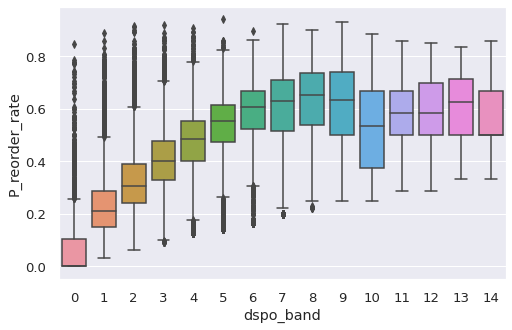

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='dspo_band',y='P_reorder_rate', data=prod_feats)
plt.show

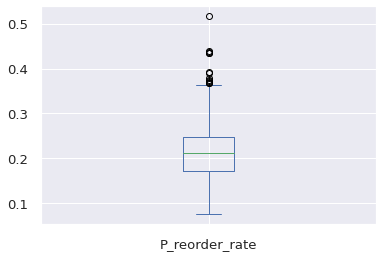

In [ ]:
x, y = 0, 1
a[(a.P_days_since_prior_order > x) & (a.P_days_since_prior_order < y)].P_reorder_rate.plot.box()

##